In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd
import matplotlib


matplotlib.use("Agg")

plots = pickle.load(open("plots/plots.pickle", "rb"))
data = pickle.load(open("data/analysis.pickle", "rb"))

## Introduction

The Workers' Compensation Board compiles an incredible amount of data on workers' comp in the state of New York. This projects utilizes a public data set to investigate the underly characteristics of these claims, identify who is most impacted, and determine important conclusions in specific questions about the data

## Exploratory Data Analysis (EDA)

The first part of this project involves preliminary data analysis. The exploratory analysis will look into three components of the data: spatial relationships, different injury types, and time series trends.

### Spatial

The data set provides claim level data on both the zip code and county level. One way to get a quick look at the spatial relationships is to plot the choropleth as a map:

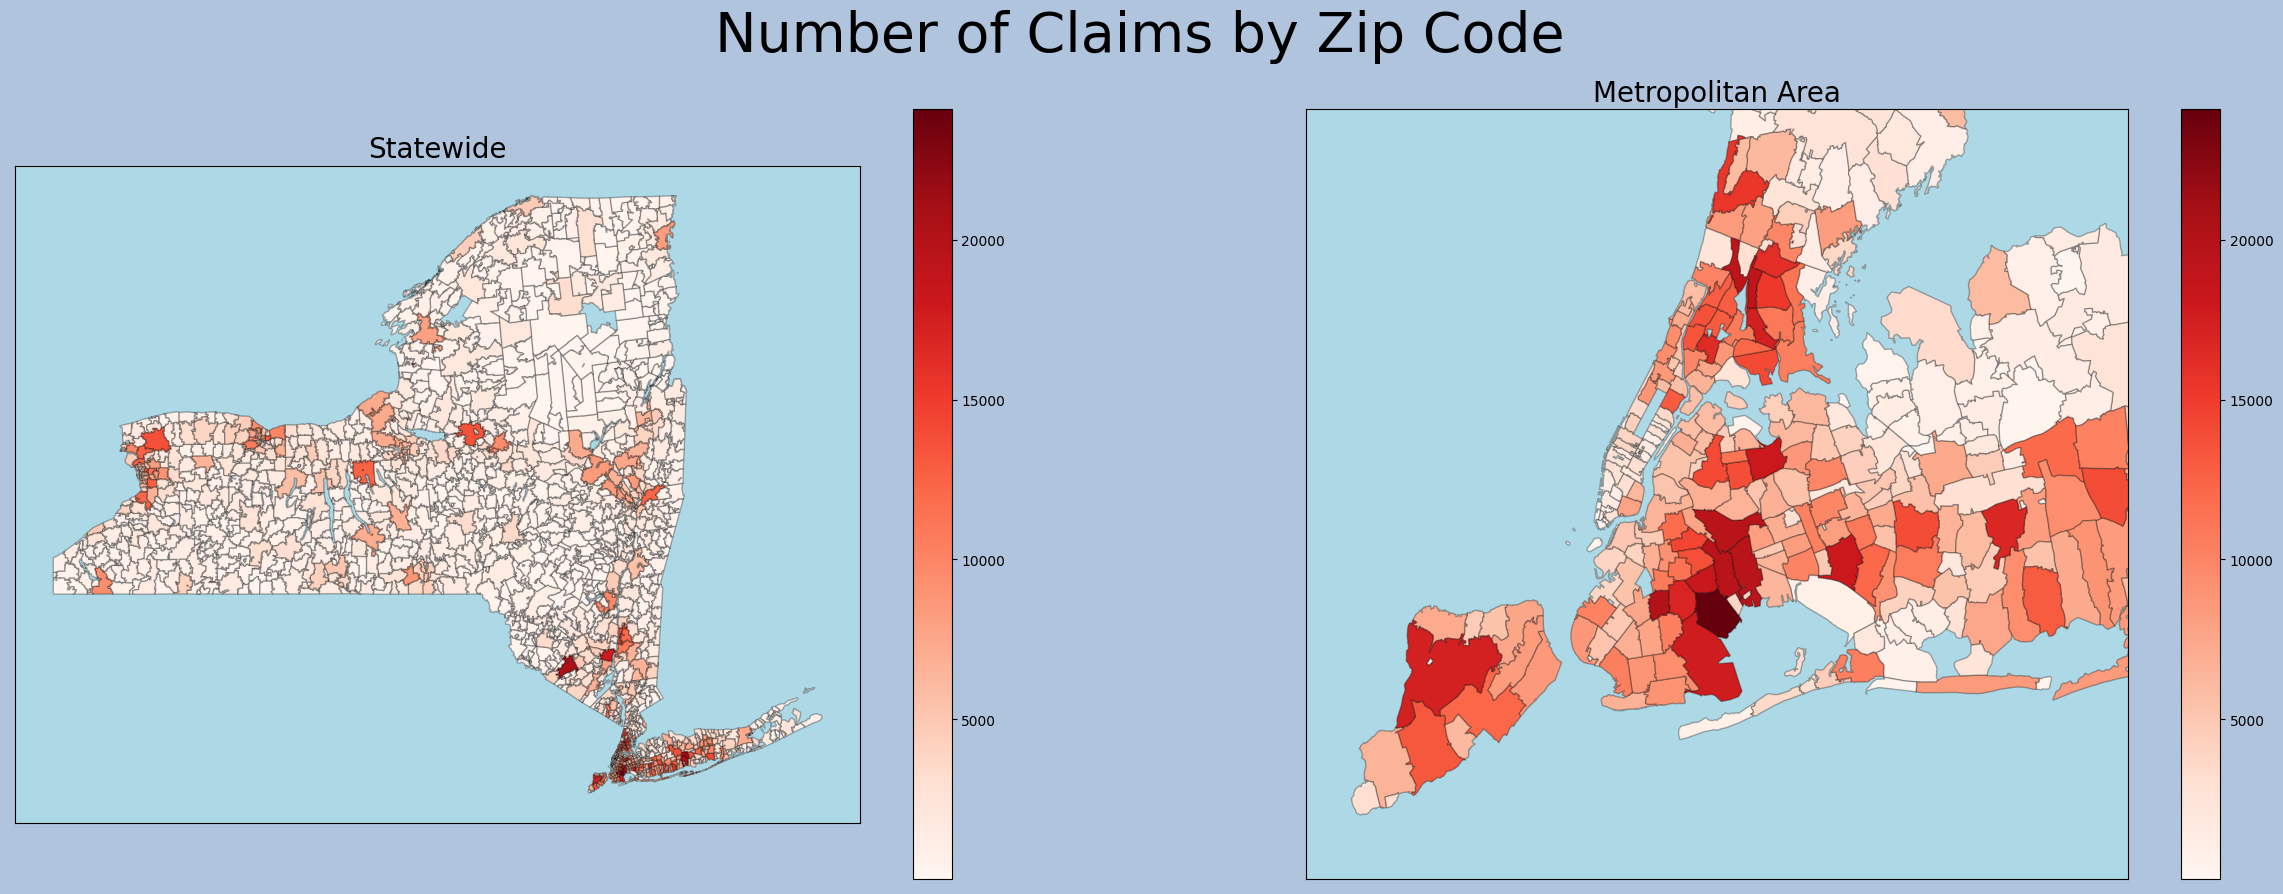

In [3]:
%matplotlib inline
plots["zip_map-count"]

As we can see, the vast majority of the state does not have quite the number of claims as New York City proper. Specifically, it appears that the section of Brooklyn on Canarsie Park produces the most claims in the data set. We can also look at this data on the county level, which is less granular and demonstrates the same result

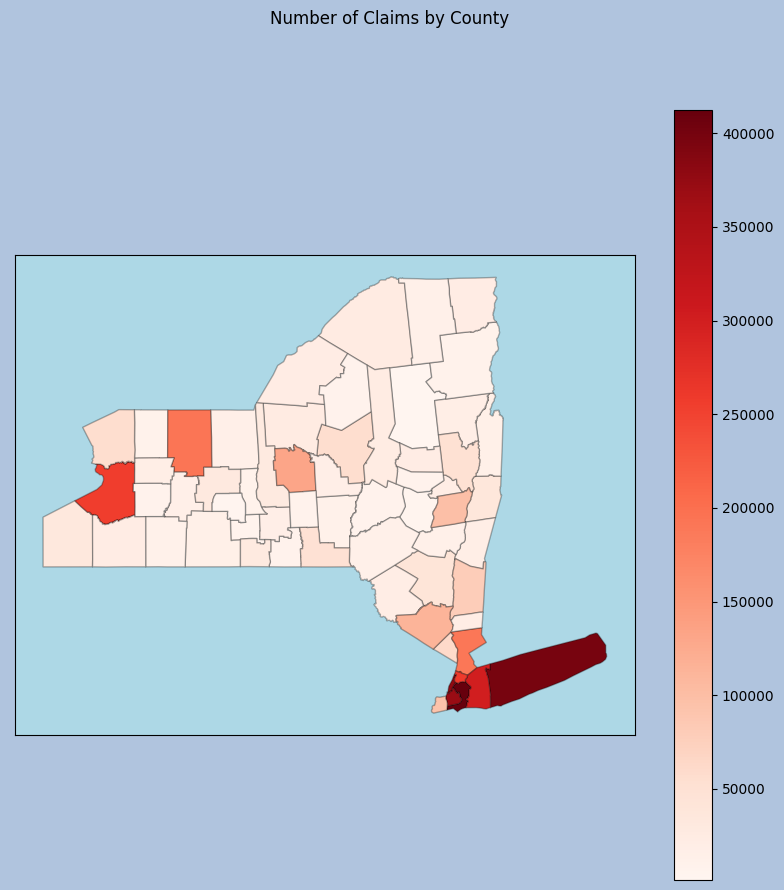

In [3]:
plots["county_map"]

However, since this tracks quite closely with the population density, it may make more sense to check the claims against the total population. I have pulled in data from the census on population by zip code, and after accounting for a few outliers (no population in the area) have produced another zip code level plot, this time on a claims-per-capita (per 1000 people) basis:

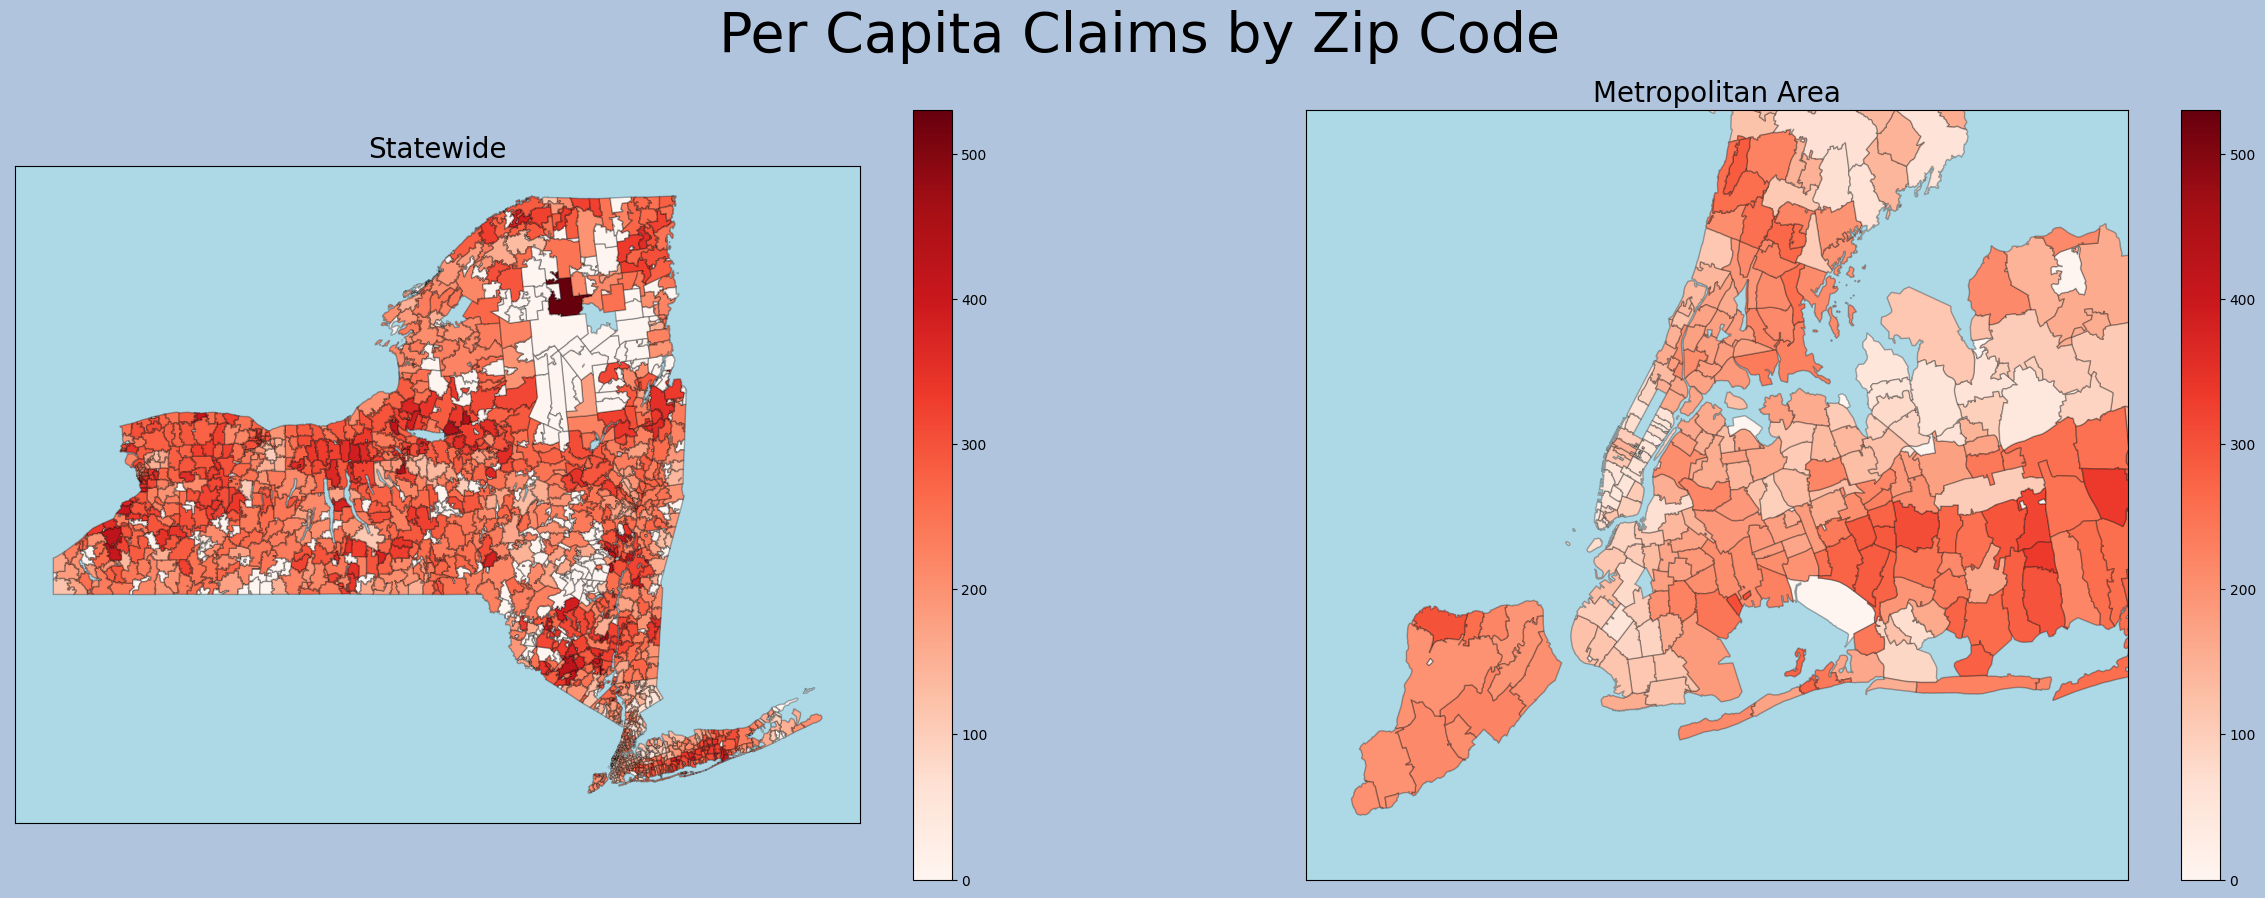

In [4]:
plots["zip_map-claims_per_capita"]

This is a much more interesting result, as New York City no longer appears to have the most abnormal geography. In fact, even the especially concentrated volume in Brooklyn appears less noteworthy and instead Long Island experiences the most claims in the metropolitan area.

### Injury Types

There are multiple organizations represented in this data set that identify the different kinds of injuries and circumstances involved in the claim. One of the organizations is the Bureau of Labor Statistics, with its Occupational Injury and Illness Classification System (OIICS); the other is a data collection non-profit, the Workers Compensation Insurance Organization (WCIO). Both the OIICS and WCIO classification systems are in terms of three different categories: The nature of the injury, the cause of the injury, and the part of body involved.

The barplot below identifies the top ten of each category, by each organization's classification system:

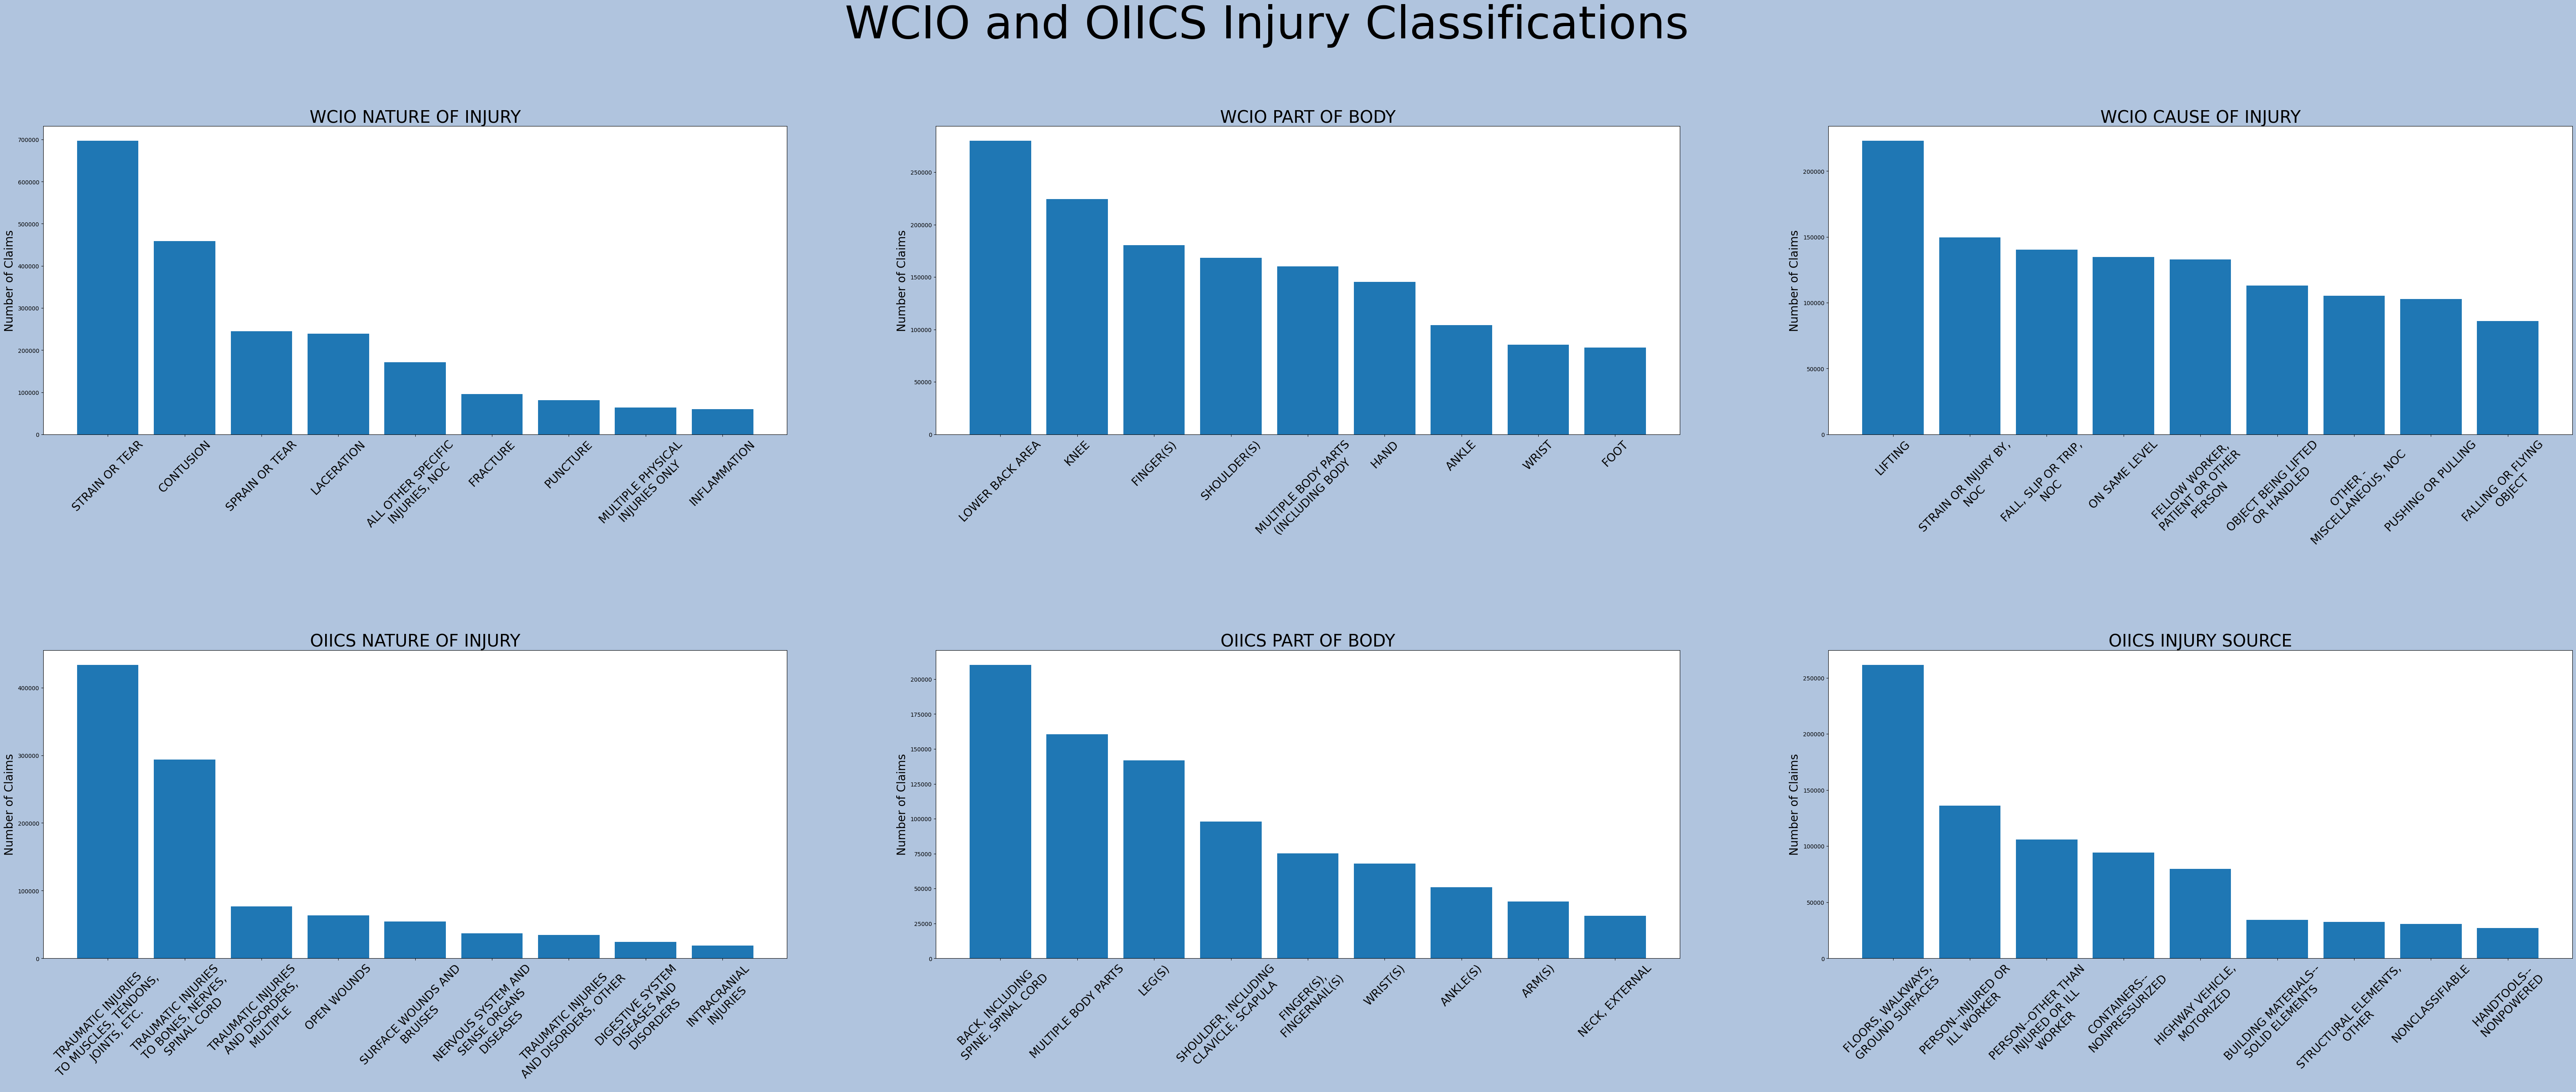

In [5]:
plots["bar"]

As we can see, the "nature of injury" is quite similar between the two organizations: the top categories are strains, brusies, lacerations. Similarly, the "part of body" is most frequently the back in both cases. The "cause of injury" and "injury source" are actually a bit different between the two classification systems, however. For the WCIO system, it is the action taken by the employee that is measured; for OIICS, it is the force acting upon the employee that is measured.

### Time Series Analysis

It is always prudent to investigate time series trends, as clear outliers in the data can skew results or mislead one's impression of a data set. In this case, there are two noteworthy spots in the timeline that I would like to point out:

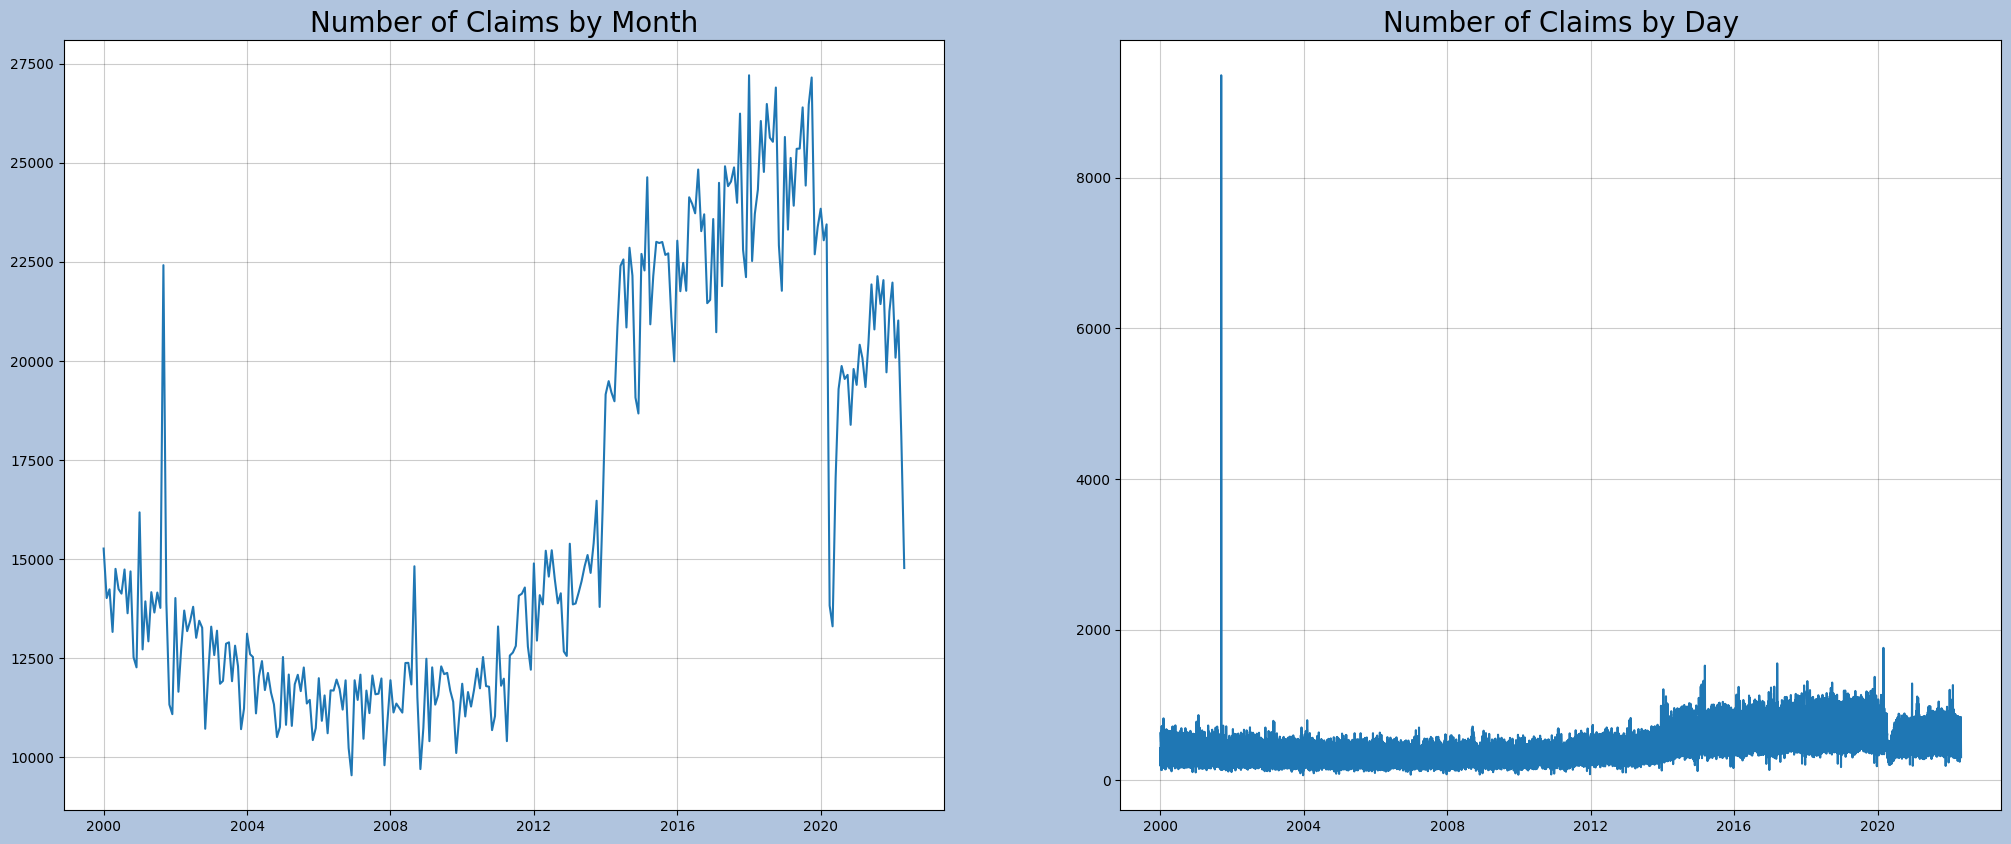

In [6]:
plots["ts-overall"]

There are two extreme results in the dataset I can explain: the first, occurs in 2001 and is 9/11; the second occurs March 2020 and is the Covid pandemic. You can easily see in the daily number of claims that 9/11 is the day which received the most claims, but it's easier to detect the covid event on the monthly data. Interestingly, the claim volume drops at the outbreak of covid - presumably because people were not permitted to go in to work.

This time frame does not paint a good picture for the daily time series though, so a more recent lookback period is plotted below, beginning in 2016:

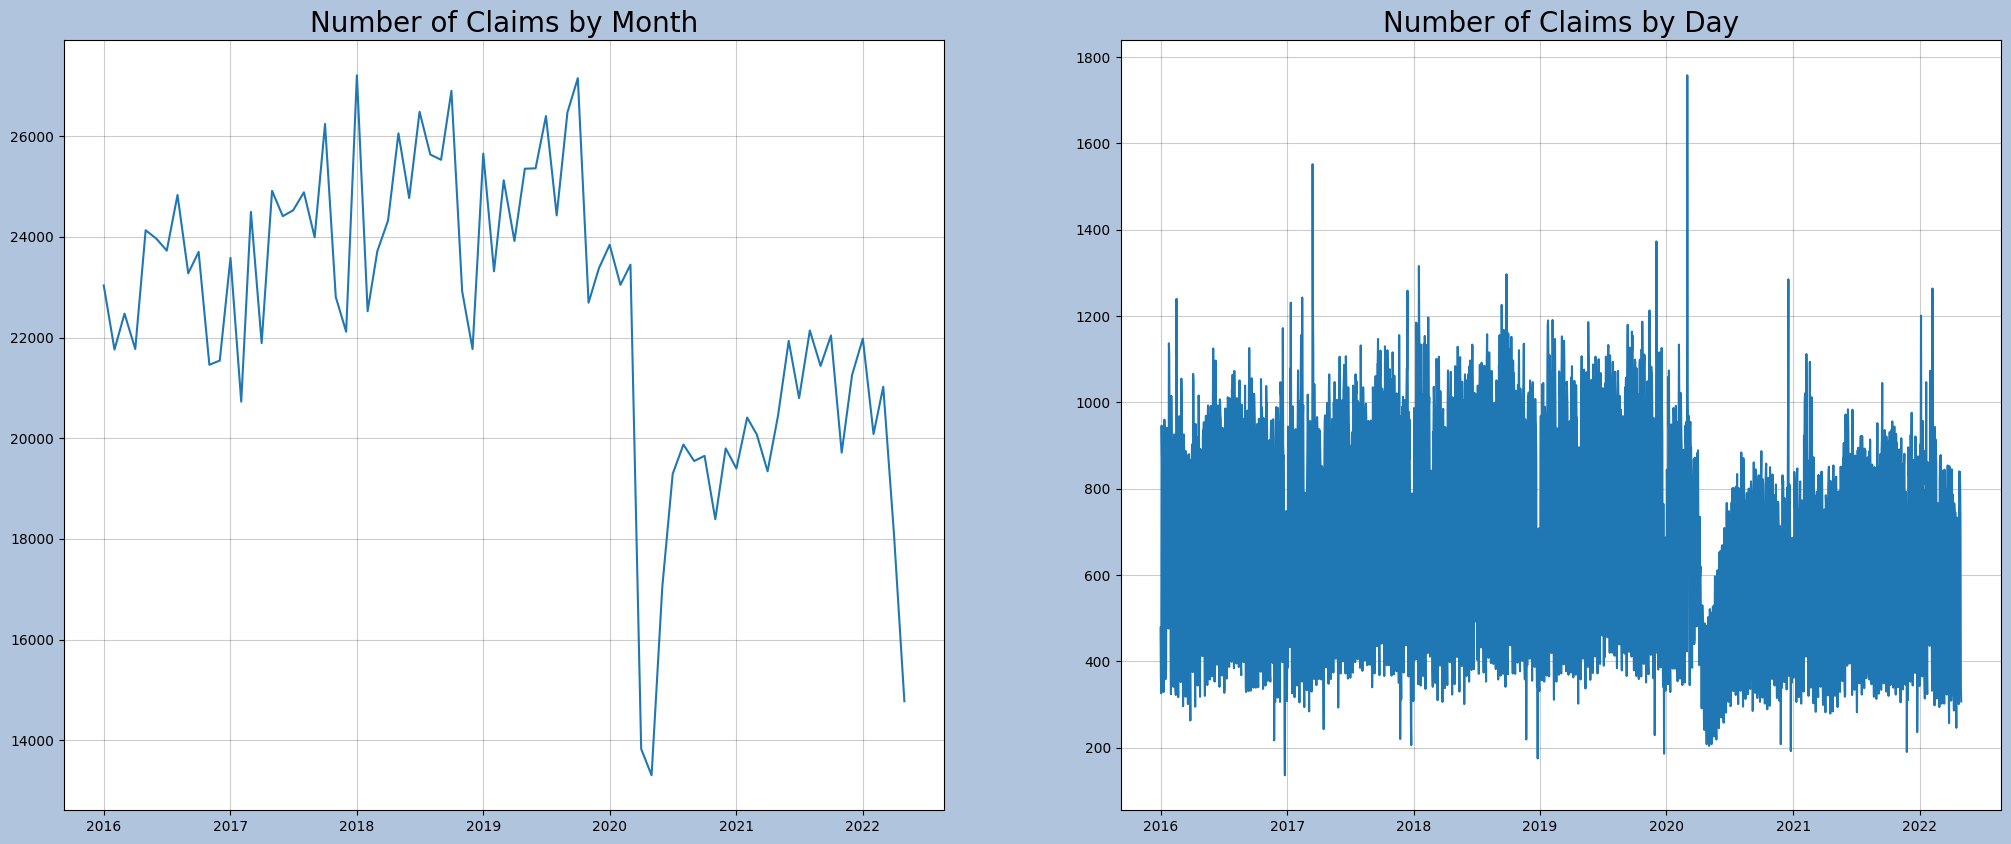

In [7]:
plots["ts-recent"]

Now, we can easily see the impact of covid on the claims volume. Additionally, we can begin to see the daily "seasonality" of a work week, though the data remains fairly muddled with a high number of observations. Below is just the past year, with only the daily plot to demonstrate the clear seasonality in the data:

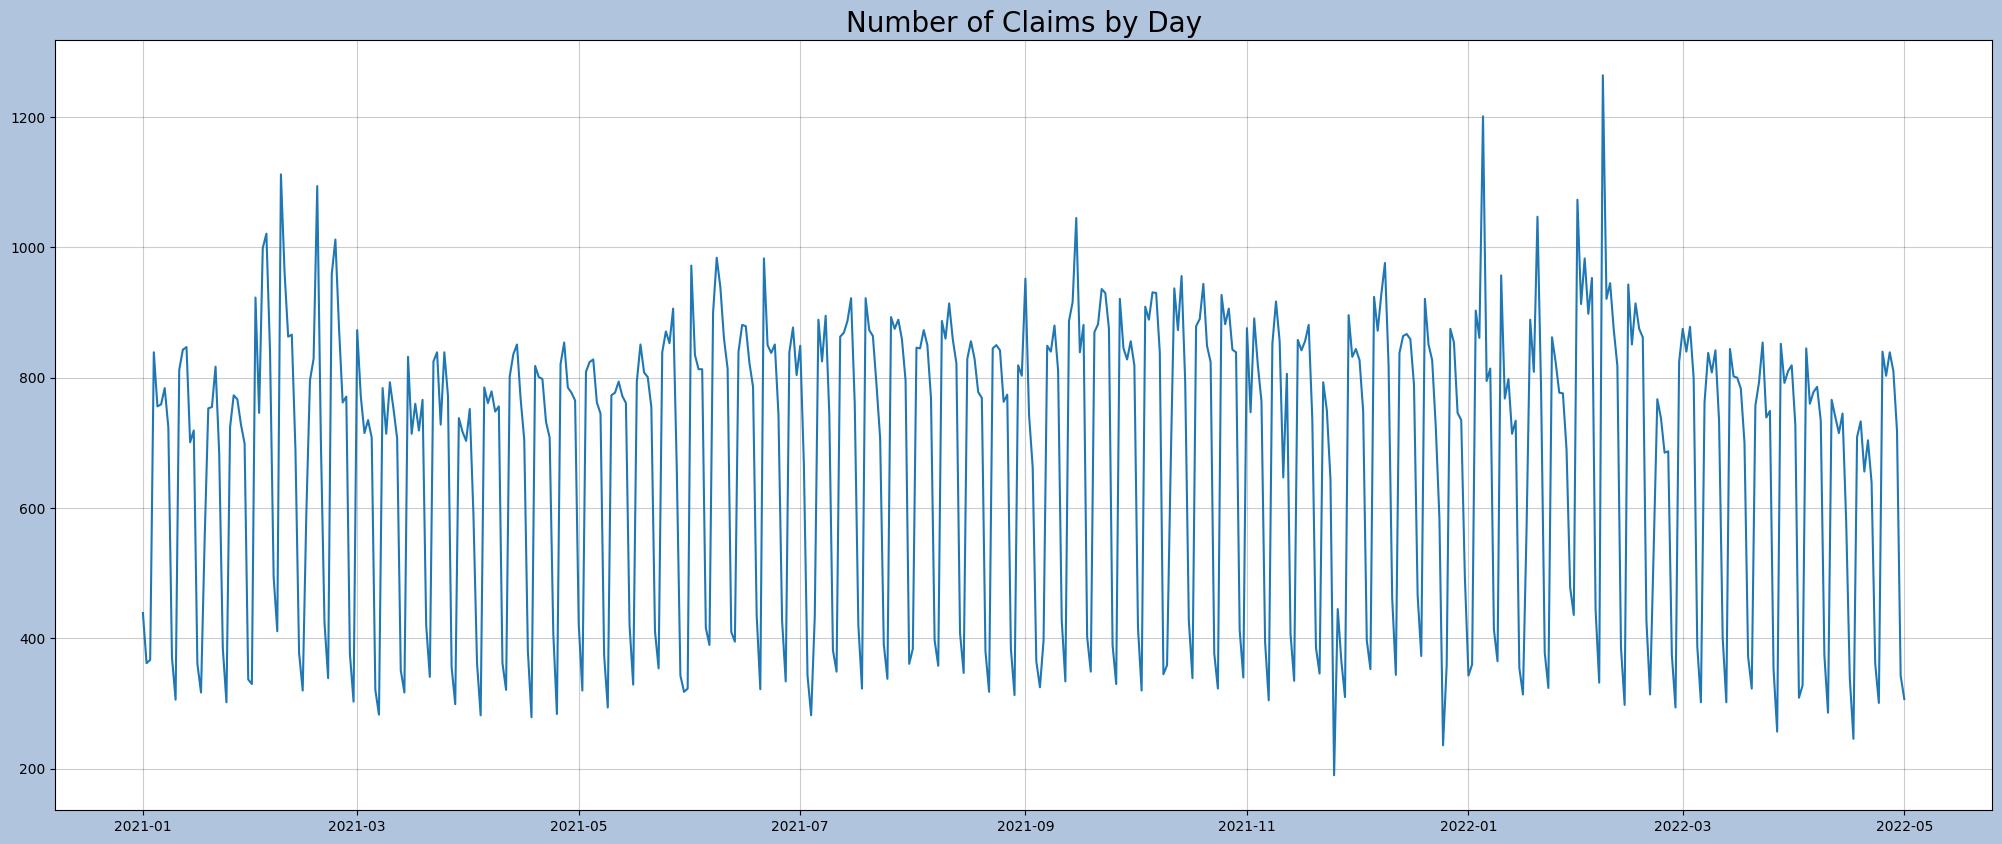

In [8]:
plots["ts-past-year"]

Next steps on this project could involve identifying the seasonality and trend components, fitting an ARIMA model, and perhaps even forecasting future claim volume.

## Hypothesis Investigations

The next step in this analysis is to test a few hypotheses of the data. The first is fairly straightforward - the idea that having a legal representative will improve one's chances of getting the claim seen by a judge. The second hypothesis is my own, which is that the claims will take longer to process with covid.

### Attorney to Judge

We have two variables of interest in this analysis: an indicator variable for the claim involving an attorney, and another indicator variable indicating the "highest process" of the claim (what status the claim ultimately reached in legal proceedings)

These can be easily pivoted (percent of column totals):

In [9]:
data["attorney_pct"]

attorney/representative,0,1
highest_process,,
1. NO RESOLUTIONS,0.534236,0.087443
2. ADMINISTRATIVE DETERMINATION,0.277463,0.071327
3B. CONCILIATION - MEETING,0.066653,0.053843
4A. HEARING - JUDGE,0.116275,0.545579
4B. HEARING - APPEAL,0.001474,0.079758
4C. HEARING - SETTLEMENT,0.003898,0.162050


As we can see, 55% of the claims that involve an attorney make it to the "Hearing - Judge" stage, whereas only 11% with no attorney make it that far. Additionally, of the records with no attorney 53% have "No Resolutions" and less than 10% of those with an attorney receive the same highest process. This strongly supports the hypothesis of a relationship between these two variables.

The simplest analysis of this problem to identify associated probabilities is to construct a logistic regression. I have already defined and fit the simple regression, turning "highest process" = "Hearing - Judge" into a dummy variable and using as a feature only the attorney column.

Here is the fitted intercept:

In [14]:
data["simple_regression"].intercept_

array([-1.29180323])

This translates to a baseline probability of 21%, meaning that without any information, the probability of the claim getting to the "Hearing - Judge" stage is 21%

In [16]:
import numpy as np
b_0 = data["simple_regression"].intercept_[0]
np.exp(b_0) / (1 + np.exp(b_0))

0.21554775120540762

Now, if we look at our coefficient, we see that it is quite large:

In [25]:
b_1 = data["simple_regression"].coef_[0][0]
b_1

1.6390080149074642

This means that the probability increases to 59% if an attorney is present. Quite an increase!

In [26]:
np.exp(b_0 + b_1) / (1 + np.exp(b_0 + b_1))

0.5859395819364991

Regressing against only the attorney column is a bit simplistic, so, after filtering the data to records that contain data, I incorporated several other variables from the data set into a multiple regression case:
- "attorney/representative"
- "age_at_injury"
- "average_weekly_wage"
- "gender"
- "ime-4_count"

This produce the following coefficients:

In [5]:
data["regression"].coef_

array([[ 0.8563718 ,  0.06331523,  0.04265333, -0.03310007, -0.14016785]])

In [30]:
data["regression"].intercept_

array([-0.3297108])

The intercept in this model is quite a bit larger than in the simplest case, indicating that the baseline probability is estimated to be 42%, a greater number than the simplest case:

In [34]:
b_0 = data["regression"].intercept_[0]
np.exp(b_0) / (1 + np.exp(b_0))

0.4183109907664052

The impact of the attorney is dampened in this case, increasing the probability to 63%

In [33]:
b_1 = data["regression"].coef_[0][0]
np.exp(b_0 + b_1) / (1 + np.exp(b_0 + b_1))

0.6287040051783049

### Accident to Assebmbly Dates and Covid

Although there is a dip in the claim volume with the crisis of Covid-19 in March 2020, I find it a little strange that volumes would go _down_ when a health crisis is in effect. I hypothesize, therefore, that the reason claims declined was simply that people were not in the office/jobsite. Once the population returned, we could expect additional claims involving coronavirus. Additionally, the actual _processors themselves_ of the claims would be impacted by covid, and therefore we could expect the time between accident date and assembly date (the very beginning of the claim processing) to increase.

To test this theory, we can again look at time series of the data. But first, we look at how the time between the _accident_ and the _assembly_  dates are distributed:

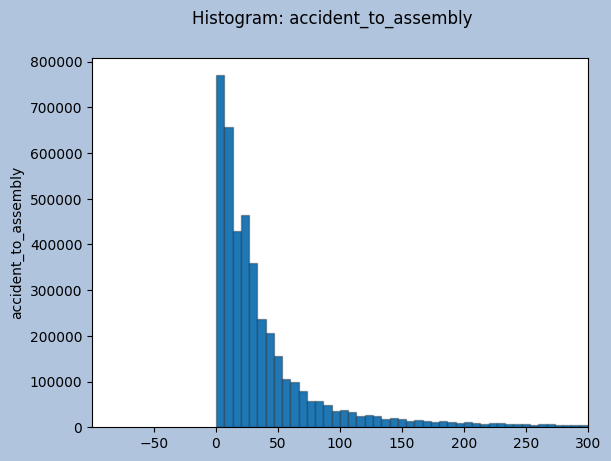

In [13]:
%matplotlib inline
plots["density-accident_to_assembly"]

This is clearly not a normal distribution, rather it approximates an exponential distribution. Therefore, we cannot use the _mean_ when looking at the "average" claim time on the time series, and should instead look to the _median_. We would expect that the mean would simply be washed out by the extreme values and instead the median would be robust.

And, in fact, we do see exactly this distinction when the time series plots are compared between mean and median:

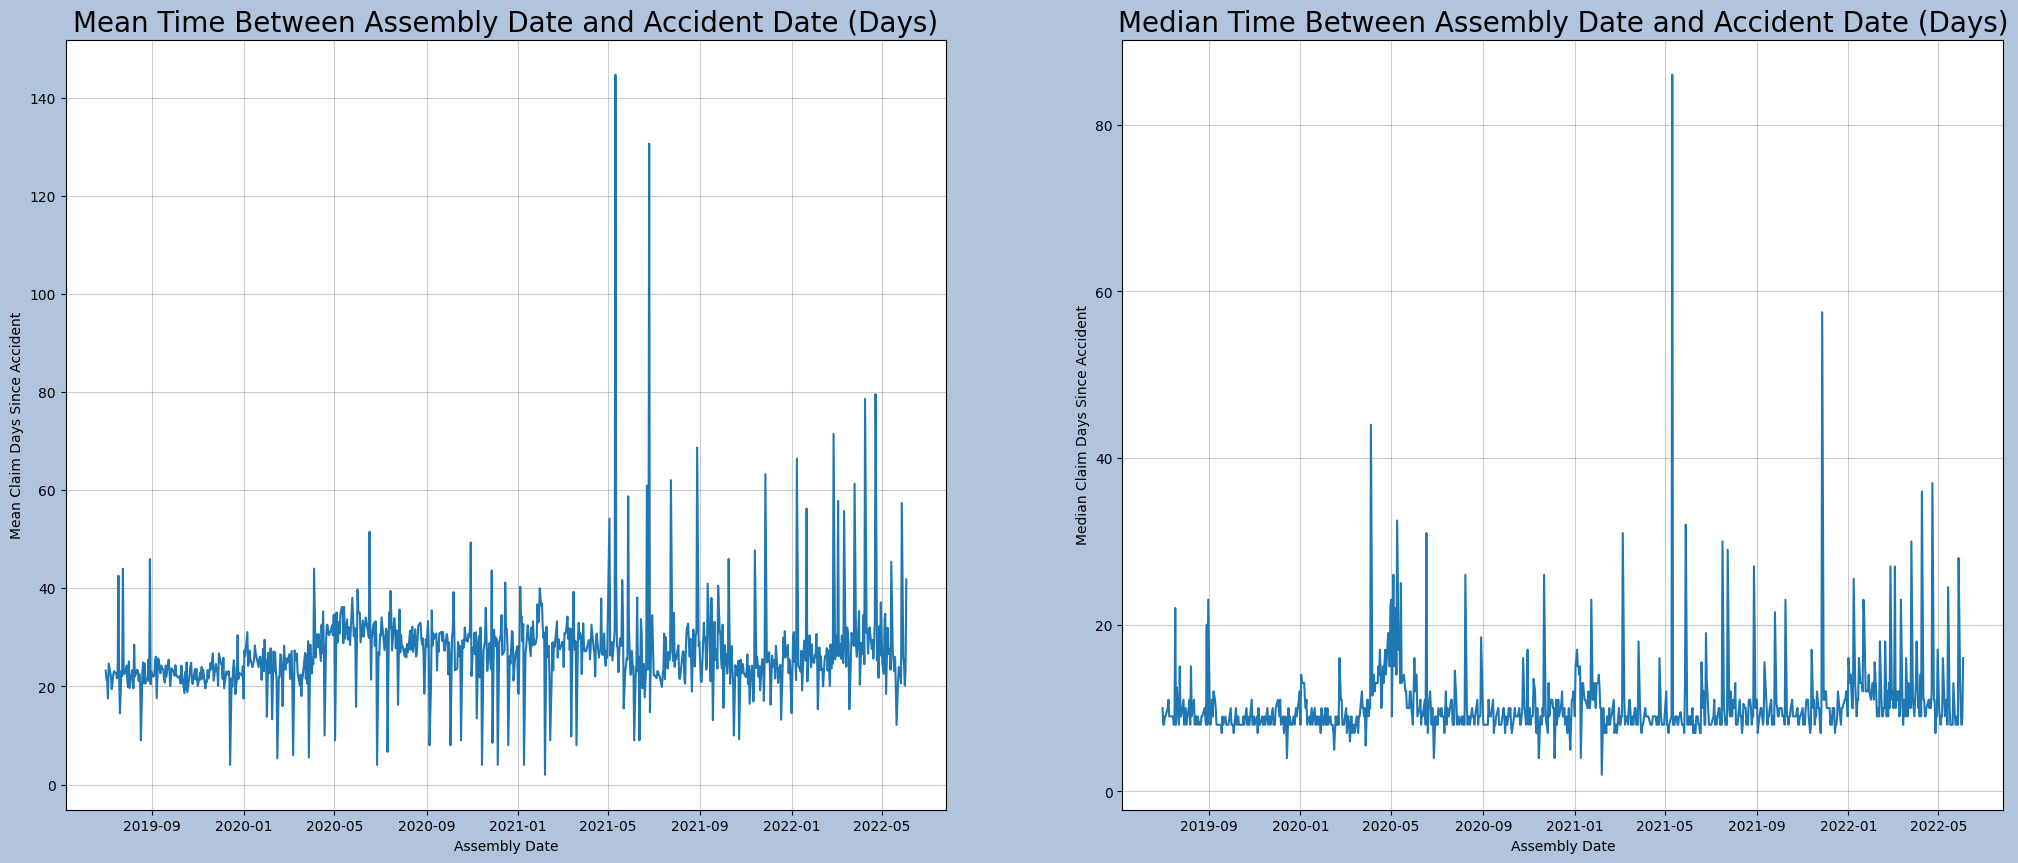

In [4]:
%matplotlib inline
plots["final"]

We can clearly see the disruption in the data in early to mid 2020 in the median data, but not the mean data. This supports the hypothesis.